In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load data from CSV
data_path = '/content/drive/My Drive/MDS/cleaned_articles.csv'
data = pd.read_csv(data_path)

# Ensure necessary columns are present
if 'row_article' not in data.columns or 'summary' not in data.columns:
    raise ValueError("Dataframe must contain 'row_article' and 'summary' columns")

# Tokenize and encode data
def encode_texts(texts, tokenizer, max_length=512):
    encoded = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    return encoded

def get_bert_embeddings(encoded, model):
    with torch.no_grad():
        outputs = model(**encoded)
        return outputs.last_hidden_state

# Encode articles and summaries
article_encoded = encode_texts(data['row_article'], bert_tokenizer)
summary_encoded = encode_texts(data['summary'], bert_tokenizer)

# Extract BERT embeddings for articles
article_embeddings = get_bert_embeddings(article_encoded, bert_model)

# Define max length for summaries
max_summary_length = 512

# Convert summaries to token IDs and pad/truncate
def adjust_summary_lengths(summaries, tokenizer, max_length):
    adjusted_summaries = []
    for text in summaries:
        tokens = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))
        if len(tokens) > max_length:
            adjusted_summary = tokens[:max_length]  # Truncate
        else:
            adjusted_summary = tokens + [0] * (max_length - len(tokens))  # Pad
        adjusted_summaries.append(adjusted_summary)
    return torch.tensor(adjusted_summaries)

summary_padded = adjust_summary_lengths(data['summary'], bert_tokenizer, max_summary_length)

# Save data
torch.save(article_encoded, '/content/drive/My Drive/MDS/article_encoded.pt')
torch.save(summary_encoded, '/content/drive/My Drive/MDS/summary_encoded.pt')
torch.save(article_embeddings, '/content/drive/My Drive/MDS/article_embeddings.pt')
torch.save(summary_padded, '/content/drive/My Drive/MDS/summary_padded.pt')

# Debugging: Print sample data
print("Sample data:", data.head())
print("Sample encoded article:", article_encoded['input_ids'][0])
print("Sample encoded summary:", summary_encoded['input_ids'][0])
print("Sample article embedding shape:", article_embeddings.shape)
print("Sample summary padded shape:", summary_padded.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sample data:    index        id                                        row_article  \
0      0  P95-1021  d tree grammars designed to share some of the ...   
1      1  P05-1073  joint learning improves semantic role labeling...   
2      2  D09-1127  bilingually constrained monolingual shift redu...   
3      3  P02-1017  a generative constituent context model for imp...   
4      4  J90-1003  word association norms mutual information and ...   

                                             summary  row_article_length  \
0  we define a new grammar formalism called d tre...               40760   
1  title joint learning improves semantic role la...               24452   
2  conclusion we have presented a novel parsing p...               24503   
3  title a generative constituent context model f...               24502   
4  we began this paper with the psycholinguistic ...               34693   

   summary_length  
0             953  
1             583  
2             776  
3          

In [3]:

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt')
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt')
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt')
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt')

# Load the original data for debugging
data_path = '/content/drive/My Drive/MDS/cleaned_articles.csv'
data = pd.read_csv(data_path)

# Debugging: Print sample data
print("Sample data:", data.head())
print("Sample encoded article:", article_encoded['input_ids'][0])
print("Sample encoded summary:", summary_encoded['input_ids'][0])
print("Sample article embedding shape:", article_embeddings.shape)
print("Sample summary padded shape:", summary_padded.shape)

# Check lengths of articles and summaries
article_lengths = [len(seq) for seq in article_encoded['input_ids']]
summary_lengths = [len(seq) for seq in summary_encoded['input_ids']]

# Print some lengths to debug
print(f"Sample article lengths: {article_lengths[:5]}")
print(f"Sample summary lengths: {summary_lengths[:5]}")

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-3-00f871f92ecc>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

Sample data:    index        id                                        row_article  \
0      0  P95-1021  d tree grammars designed to share some of the ...   
1      1  P05-1073  joint learning improves semantic role labeling...   
2      2  D09-1127  bilingually constrained monolingual shift redu...   
3      3  P02-1017  a generative constituent context model for imp...   
4      4  J90-1003  word association norms mutual information and ...   

                                             summary  row_article_length  \
0  we define a new grammar formalism called d tre...               40760   
1  title joint learning improves semantic role la...               24452   
2  conclusion we have presented a novel parsing p...               24503   
3  title a generative constituent context model f...               24502   
4  we began this paper with the psycholinguistic ...               34693   

   summary_length  
0             953  
1             583  
2             776  
3          

In [ ]:
import torch
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

def save_model(model, vocab_size, embedding_dim, hidden_dim, output_dim, num_epochs, batch_size, model_save_path):
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab_size': output_dim,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'output_dim': output_dim,
            'num_epochs': num_epochs,
            'batch_size': batch_size
        }, model_save_path)
        logging.info(f"Model saved to {model_save_path}")
    except Exception as e:
        logging.error(f"Error saving the model: {e}")
        raise


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Output dim: 30522
Batch X shape: torch.Size([4, 512, 768])
Batch y shape: torch.Size([4, 512])
Epoch 1/10
Epoch 1 ---- Training Batch 1/107
Batch Size: 4, Sequence Length: 512
Reshaped Outputs shape: torch.Size([2048, 30522])
Reshaped y_batch shape: torch.Size([2048])
Epoch 1 ---- Training Batch 2/107
Batch Size: 4, Sequence Length: 512
Reshaped Outputs shape: torch.Size([2048, 30522])
Reshaped y_batch shape: torch.Size([2048])
Epoch 1 ---- Training Batch 3/107
Batch Size: 4, Sequence Length: 512
Reshaped Outputs shape: torch.Size([2048, 30522])
Reshaped y_batch shape: torch.Size([2048])
Epoch 1 ---- Training Batch 4/107
Batch Size: 4, Sequence Length: 512
Reshaped Outputs shape: torch.Size([2048, 30522])
Reshaped y_batch shape: torch.Size([2048])
Epoch 1 ---- Training Batch 5/107
Batch Size: 4, Sequence Length: 512
Reshaped Outputs shape: torch.Size([2048, 30522])
Reshaped y_batch shape: torch.Size([2048])
Epoch 1 ---- Training Batch 6/107
Batch Size: 4, Sequence Length: 512
Reshaped 

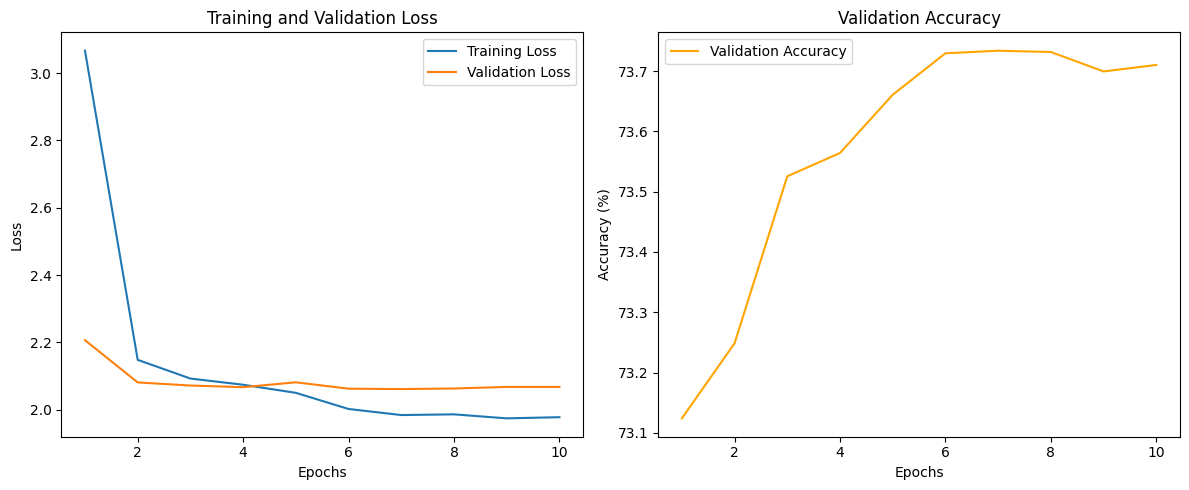

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # Set BERT to evaluation mode

# Load encoded data
article_encoded = torch.load('/content/drive/My Drive/MDS/article_encoded.pt', weights_only=False)
summary_encoded = torch.load('/content/drive/My Drive/MDS/summary_encoded.pt', weights_only=False)
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt', weights_only=False)
summary_ids = torch.load('/content/drive/My Drive/MDS/summary_ids.pt', weights_only=False)
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt', weights_only=False)

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply linear layer to every token's LSTM output
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output

# Define model parameters
input_dim = bert_model.config.hidden_size  # Size of BERT embeddings (usually 768 for bert-base)
hidden_dim = 128
output_dim = len(bert_tokenizer)  # Size of the vocabulary for the output layer
print(f"Output dim: {output_dim}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMWithAttention(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler

# Create dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4
num_epochs = 10
total_batches=608/batch_size
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check DataLoader output
for X_batch, y_batch in train_dataloader:
    print("Batch X shape:", X_batch.shape)
    print("Batch y shape:", y_batch.shape)
    break  # Remove this break to see more batches


import torch
import numpy as np

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, save_path='trained_model.pth'):
    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Ensure the model is in training mode
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        batch_no = 0

        # Initialize total loss for training
        total_loss = 0
        model.train()  # Set model to training mode

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            batch_no += 1
            # Forward pass
            outputs = model(X_batch)
            print(f"Epoch {epoch+1} ---- Training Batch {batch_no}/{len(train_dataloader)}")

            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len = X_batch.size(0), X_batch.size(1)
            print(f"Batch Size: {batch_size}, Sequence Length: {seq_len}")

            outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
            print(f"Reshaped Outputs shape: {outputs.shape}")
            y_batch = y_batch.view(-1)  # [batch_size * seq_len]
            print(f"Reshaped y_batch shape: {y_batch.shape}")

            # Compute loss
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Update the learning rate
        scheduler.step()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Forward pass
                outputs = model(X_batch)

                # Reshape outputs and targets for CrossEntropyLoss
                outputs = outputs.view(-1, output_dim)  # [batch_size * seq_len, output_dim]
                y_batch = y_batch.view(-1)  # [batch_size * seq_len]

                # Compute loss
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, dim=1)
                correct_preds += (predicted == y_batch).sum().item()
                total_preds += y_batch.size(0)

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = correct_preds / total_preds
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Learning Rate: {scheduler.get_last_lr()}")

        # Save the model after each epoch
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
                'vocab_size': output_dim,  # Assuming output_dim is the vocabulary size
                'embedding_dim': input_dim,  # Size of BERT embeddings
                'hidden_dim': hidden_dim,  # Hidden dimension size of LSTM
                'num_epochs': num_epochs,
                'batch_size': batch_size
            }, save_path)
            print(f"Model saved to {save_path}")
        except Exception as e:
            print(f"Error saving the model: {e}")

        # Debug: Check for NaN values in losses
        if torch.isnan(torch.tensor(avg_train_loss)) or torch.isnan(torch.tensor(avg_val_loss)):
            raise ValueError("NaN values encountered in loss.")

    return train_losses, val_losses, val_accuracies

import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [a * 100 for a in val_accuracies], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training
train_losses, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs)
plot_metrics(train_losses, val_losses, val_accuracies)


# Define the model save path
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'



In [ ]:
import torch

# Define Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

# Define BiLSTM with Attention Model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply linear layer to every token's LSTM output
        output = self.fc(lstm_output)  # Output shape: [batch_size, seq_len, output_dim]
        return output


# Load the saved model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['output_dim']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

# Define the model path
model_path = '/content/drive/My Drive/MDS/trained_model.pth'
model = load_model(model_path)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


In [6]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=ea13d0ae3f50f371a8a3c5fffebcc87fee6888d1d508d4335c797a5e6ffe7f10
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from rouge_score import rouge_scorer
import numpy as np

# Define the model classes (BiLSTM with Attention)
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim)
        self.wa = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.wa(torch.tanh(self.Wa(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context_vector.squeeze(1)

class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Output for each token position

    def forward(self, x):
        lstm_output, _ = self.lstm(x)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        context_vector = self.attention(lstm_output)
        output = self.fc(context_vector)  # Output shape: [batch_size, output_dim]
        return output

# Define a function to load the model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model = BiLSTMWithAttention(
        input_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        output_dim=checkpoint['vocab_size']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set model to evaluation mode
    return model

# Define a function to generate summaries
def generate_summaries(model, dataloader, device):
    model.eval()
    generated_summaries = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)

            # Convert logits to token IDs
            summaries = torch.argmax(outputs, dim=-1)  # Get the predicted tokens
            generated_summaries.extend(summaries.cpu().numpy())

    return generated_summaries

# Define a function to decode token IDs into text
def decode_tokens(token_ids, tokenizer):
    """
    Decode a list of token IDs into human-readable text using a tokenizer.
    Includes debugging steps to ensure proper token decoding.

    Args:
        token_ids (list or numpy.ndarray): List of token IDs to decode.
        tokenizer (BertTokenizer): The tokenizer used for encoding and decoding.

    Returns:
        List of decoded summaries as strings.
    """
    decoded_summaries = []

    if isinstance(token_ids[0], (list, np.ndarray)):
        for idx, ids in enumerate(token_ids):
            print(f"\nDecoding batch index {idx}")
            print(f"Original Token IDs: {ids[:20]}...")  # Print the first 20 IDs for inspection

            # Remove padding tokens
            ids = list(filter(lambda x: x != tokenizer.pad_token_id, ids))
            print(f"Token IDs after removing padding: {ids[:20]}...")

            # Convert IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True)
            print(f"Tokens: {tokens[:20]}...")

            # Convert tokens to string
            decoded_text = tokenizer.convert_tokens_to_string(tokens)
            print(f"Decoded Text: {decoded_text[:100]}...")  # Print the first 100 characters

            decoded_summaries.append(decoded_text)
    else:
        print(f"\nDecoding single set of token IDs")
        print(f"Original Token IDs: {token_ids[:20]}...")

        # Remove padding tokens
        token_ids = list(filter(lambda x: x != tokenizer.pad_token_id, token_ids))
        print(f"Token IDs after removing padding: {token_ids[:20]}...")

        # Convert IDs to tokens
        tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=True)
        print(f"Tokens: {tokens[:20]}...")

        # Convert tokens to string
        decoded_text = tokenizer.convert_tokens_to_string(tokens)
        print(f"Decoded Text: {decoded_text[:100]}...")

        decoded_summaries.append(decoded_text)

    return decoded_summaries

# Define a function to calculate ROUGE scores
def calculate_rouge_scores(generated_summaries, reference_summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for idx, (generated, reference) in enumerate(zip(generated_summaries, reference_summaries)):
        print(f"\nCalculating ROUGE scores for sample index {idx}")
        print(f"Generated Summary: {generated}")
        print(f"Reference Summary: {reference}")

        score = scorer.score(reference, generated)
        for key in scores.keys():
            scores[key].append(score[key].fmeasure)
            print(f"{key} F-measure: {score[key].fmeasure:.4f}")

    avg_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    return avg_scores

# Define a function to test the model and evaluate with ROUGE
def test_model(model_path, test_dataloader, device, tokenizer):
    # Load the model
    model = load_model(model_path).to(device)

    # Generate summaries
    generated_summaries = generate_summaries(model, test_dataloader, device)

    # Decode generated summaries
    decoded_generated_summaries = decode_tokens(generated_summaries, tokenizer)

    # Extract reference summaries from the dataloader
    reference_summaries = []
    for _, y_batch in test_dataloader:
        reference_summaries.extend(y_batch.cpu().numpy())

    # Decode reference summaries
    decoded_reference_summaries = decode_tokens(reference_summaries, tokenizer)

    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(decoded_generated_summaries, decoded_reference_summaries)

    print("ROUGE Scores:")
    for key, score in rouge_scores.items():
        print(f"{key}: {score:.4f}")

# Create dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into train, validation, and test sets
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    num_samples = len(X)
    indices = torch.randperm(num_samples).tolist()
    train_end = int(num_samples * train_size)
    val_end = train_end + int(num_samples * val_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = torch.stack([X[i] for i in train_indices])
    y_train = torch.stack([y[i] for i in train_indices])
    X_val = torch.stack([X[i] for i in val_indices])
    y_val = torch.stack([y[i] for i in val_indices])
    X_test = torch.stack([X[i] for i in test_indices])
    y_test = torch.stack([y[i] for i in test_indices])

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Load encoded data
article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
summary_padded = torch.load('/content/drive/My Drive/MDS/summary_padded.pt')

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(article_embeddings, summary_padded)

# Create DataLoaders
batch_size = 4

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to model
model_save_path = '/content/drive/My Drive/MDS/trained_model.pth'

# Test the model and calculate ROUGE scores
test_model(model_save_path, test_dataloader, device, bert_tokenizer)


<ipython-input-20-348441534f2c>:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  article_embeddings = torch.load('/content/drive/My Drive/MDS/article_embeddings.pt')
<ipyt


Decoding single set of token IDs
Original Token IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
Token IDs after removing padding: []...
Tokens: []...
Decoded Text: ...

Decoding batch index 0
Original Token IDs: [ 2516  2220  3463  2005  2315  9178  5038  2007 18462  6721  4249  3444
 15946  1998  4773  9412 16105  8663  3736  5910]...
Token IDs after removing padding: [2516, 2220, 3463, 2005, 2315, 9178, 5038, 2007, 18462, 6721, 4249, 3444, 15946, 1998, 4773, 9412, 16105, 8663, 3736, 5910]...
Tokens: ['title', 'early', 'results', 'for', 'named', 'entity', 'recognition', 'with', 'conditional', 'random', 'fields', 'feature', 'induction', 'and', 'web', 'enhanced', 'lexi', '##con', '##sa', '##bs']...
Decoded Text: title early results for named entity recognition with conditional random fields feature induction an...

Decoding batch index 1
Original Token IDs: [ 1996  3463  2265  2008  6882  9312  2478  4895  8004  6444  2522 10085
 10841 14343  5897  2015  2090 12654